 **This is an open-ended self-directed assignment made for UBC CPSC 330 - Applied Machine Learning.**

 In this project, we aim to find a suitable machine learning model to predict if a person will default on their credit card using scikit-learn.

## Imports

In [1]:
import os

%matplotlib inline
import string
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import re
import sys
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer

<br><br>

## 1. Defining and Explaining the Problem <a name="1"></a>
<hr>

In [2]:
df = pd.read_csv("data/UCI_Credit_Card.csv", index_col=0)
print(df.isnull().values.any()) # True means there exists NA values, False means no NA values
df.head()

False


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
3,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
4,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
5,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


> Some initial thoughts:
> - We are trying to predict the column `default.payment.next.month`, which is a binary variable with `1 = Yes` and `0 = No` to defaulting next month's payment. Since we are trying to predict a binary outcome, our model would be a classifier, utilizing processes such as logistic regression or decision tree classification.
> - All features are in numeric form, AND there does not exist any NA values -> Suggests that depending on what we find in EDA, the only preprocessing step we may need is scaling if the categorical data is properly encoded already.
>   - That being said, many of the features are categorical features that have been converted to numeric form. (e.g. `SEX` feature has `1 = Male`, `2 = Female`)
>     - Some of these categorical features are ordered, such as `EDUCATION` or the `PAY_X` columns
> - ID is a label column, and not a feature. Thus it should be excluded from our model (and used as the index column instead. This has been done above when reading in the data).

<!-- END QUESTION -->

<br><br>

## 2. Data Splitting <a name="2"></a>
<hr>

In [3]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=76) # 70% training, 30% testing, random state of 76

# Separate features from target (For model later)
X_train, y_train = train_df.drop(columns='default.payment.next.month'), train_df['default.payment.next.month']
X_test, y_test = test_df.drop(columns='default.payment.next.month'), test_df['default.payment.next.month']

<!-- END QUESTION -->

<br><br>

## 3. Exploratory Data Analysis<a name="3"></a>
<hr>

In [4]:
default_summary = train_df.describe(include='all')
display(default_summary)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,...,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,167563.508571,1.604381,1.843905,1.554667,35.412952,-0.012190,-0.132714,-0.168333,-0.223143,-0.265762,...,43039.813952,40121.889810,38623.497095,5601.265286,6.059441e+03,5204.302571,4889.281333,4782.900857,5162.918714,0.221857
std,129919.112502,0.488995,0.789845,0.521970,9.136302,1.121864,1.196554,1.195375,1.165490,1.134210,...,63817.414980,60400.798292,59055.005208,16239.423781,2.407470e+04,16865.645456,16486.840852,15431.523094,17170.608569,0.415505
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-209051.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2300.000000,1800.000000,1266.250000,1000.000000,8.200000e+02,390.000000,291.000000,257.750000,150.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,18990.000000,18091.000000,17127.000000,2112.500000,2.009000e+03,1801.500000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54740.000000,50065.250000,48950.500000,5012.000000,5.000000e+03,4531.250000,4048.500000,4078.000000,4001.000000,0.000000
max,800000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,706864.000000,823540.000000,568638.000000,873552.000000,1.684259e+06,889043.000000,621000.000000,426529.000000,528666.000000,1.000000


> Firstly, note that the `count` of all variables is the same at 21000. This again reaffirms that there is no missing data, as all columns have the same count.

> From the above, we can see that the mean value of `default.payment.next.month` (the target) observed in our training set is 0.221857. Since the target is a binary variable, this suggests that ~78% of the training set's target variable has a value of 0 (no default) and ~22% of the training set's target variable has a value of 1 (default). This class imbalance points to potential questions on whether accuracy is the best metric to use to score our future models.

> We can also observe other skews in the data, such as how the mean of the `SEX` column is 1.6. Since `1 = Male` and `2 = Female`, this shows that there are more females than males included in our training set.

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21000 entries, 8959 to 2722
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LIMIT_BAL                   21000 non-null  float64
 1   SEX                         21000 non-null  int64  
 2   EDUCATION                   21000 non-null  int64  
 3   MARRIAGE                    21000 non-null  int64  
 4   AGE                         21000 non-null  int64  
 5   PAY_0                       21000 non-null  int64  
 6   PAY_2                       21000 non-null  int64  
 7   PAY_3                       21000 non-null  int64  
 8   PAY_4                       21000 non-null  int64  
 9   PAY_5                       21000 non-null  int64  
 10  PAY_6                       21000 non-null  int64  
 11  BILL_AMT1                   21000 non-null  float64
 12  BILL_AMT2                   21000 non-null  float64
 13  BILL_AMT3                   21000 

> The above displays useful information about each of our features. Some useful points are:
> - Note that Non-Null Count is 21000 for each column (which we saw a few times previously)
> - We do not have any features in non-numeric form. However, some of the features with `int64` datatype are categorical features converted to a numeric form. Description of these categorical features can be found on the website where the dataset is sourced from.

>Our numerical features (in this case, the numeric variables that do not represent categories) are `LIMIT_BAL`, `AGE`, `BILL_AMT1` through `BILL_AMT6`, and `PAY_AMT1` through `PAY_AMT6`. Let us plot the distributions of these variables to see which features may be relevant for our prediction task:

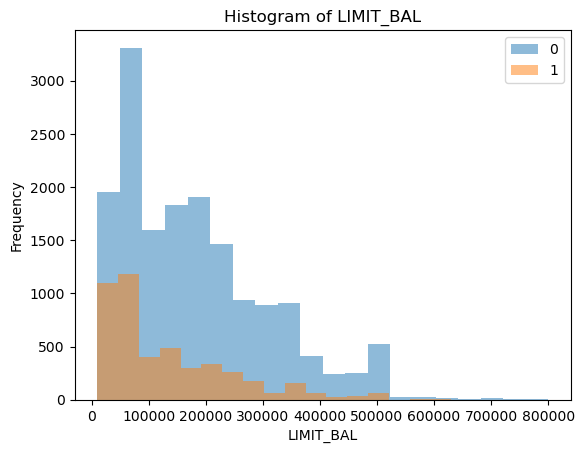

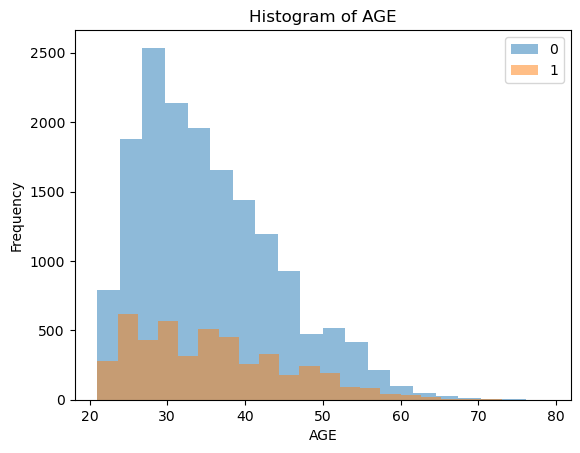

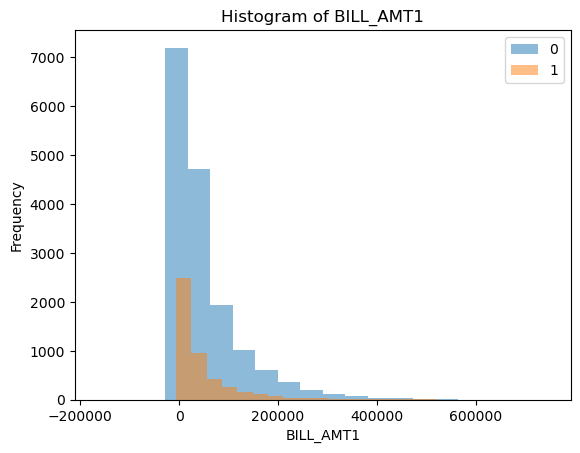

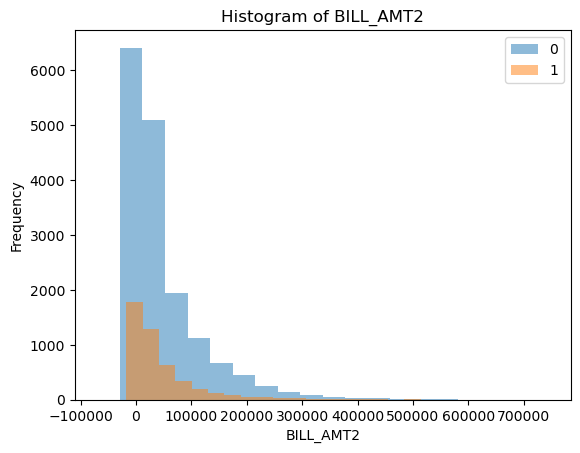

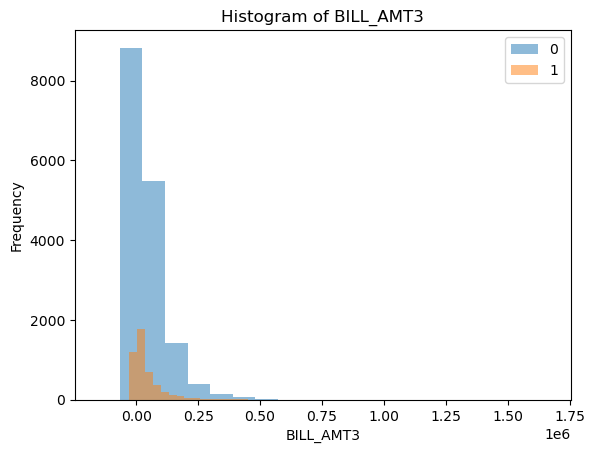

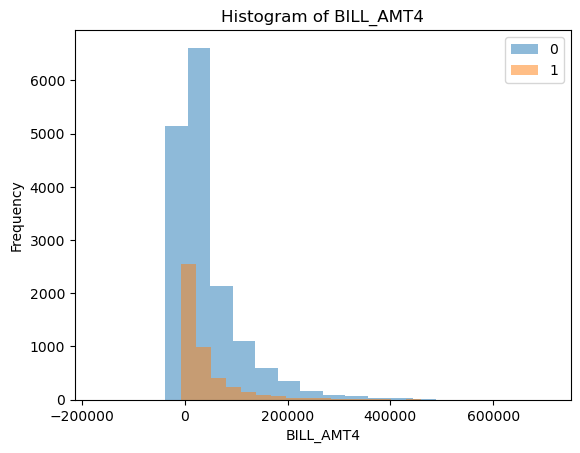

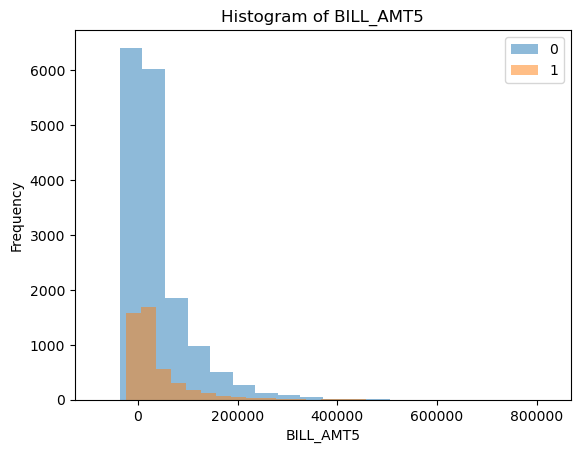

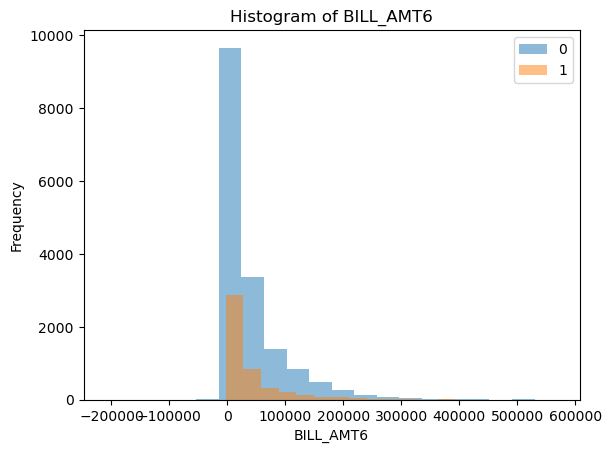

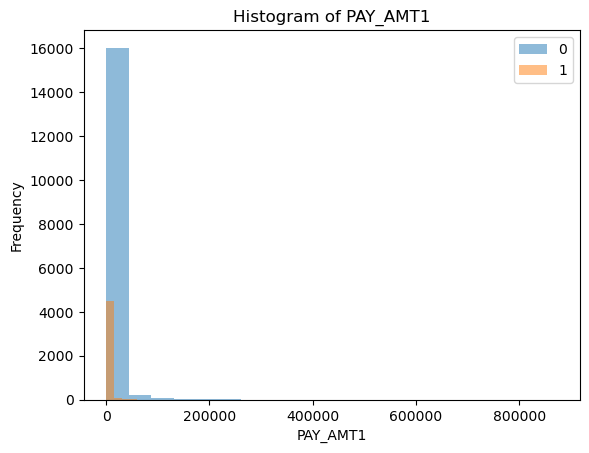

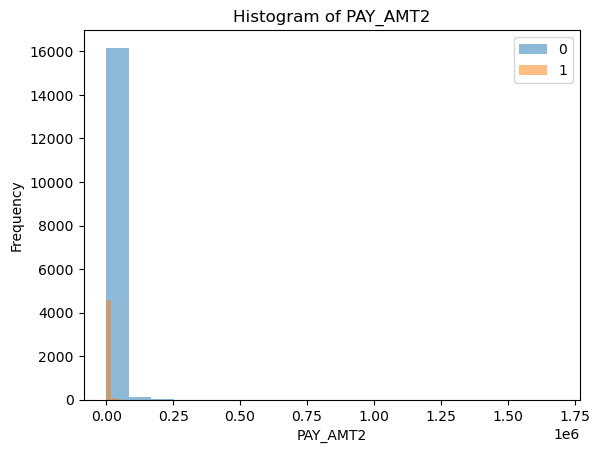

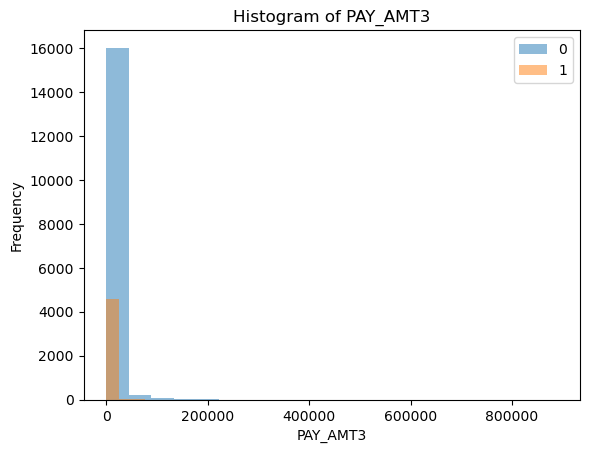

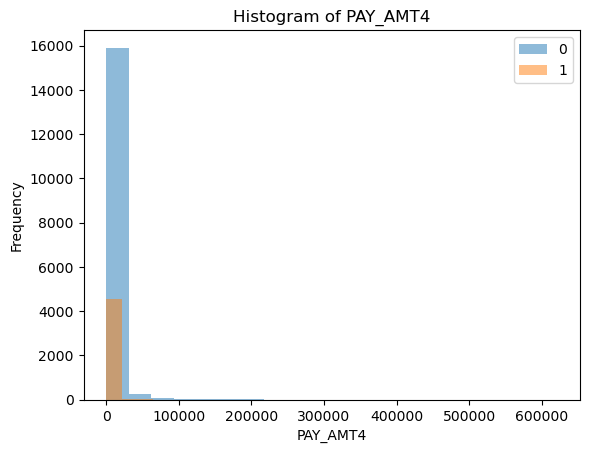

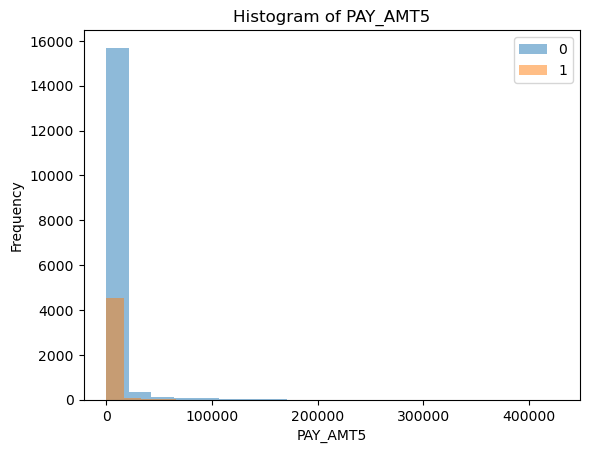

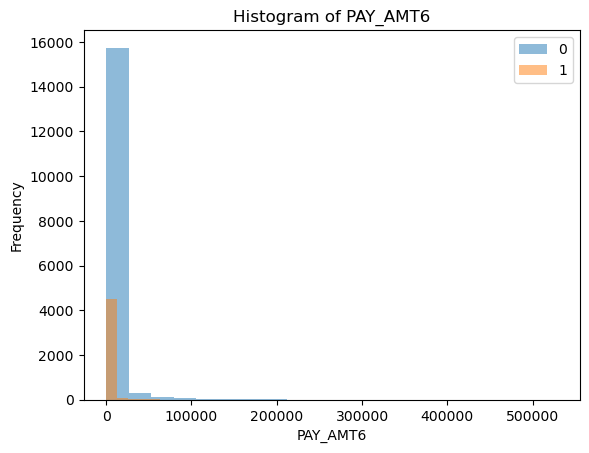

In [6]:
numeric_cols = ['LIMIT_BAL', 'AGE',
                'BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
                'PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']

# Adapted from hw2/hw3 answer
for feat in numeric_cols:
    ax = train_df.groupby("default.payment.next.month")[feat].plot.hist(bins=20, alpha=0.5, legend=True)
    plt.xlabel(feat)
    plt.title("Histogram of " + feat)
    plt.show()

> Numeric features that would appear relevant at first glance are the ones in which the distribution of default=0 and default=1 are not the same. Observing these (unscaled) histograms, we can not conclude that any of these numeric features have identical distributions, thus we will keep each feature for training the model.

> We can also observe that `EDUCATION` and `PAY_0`,`PAY_2`,...,`PAY_6` are ordered variables.
> 
> (EDUCATION: 1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
> 
> (PAY_X: -1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ..., 8=payment delay for eight months, 9=payment delay for nine months and above)
>
> Fortunately, these are already ordered, and in the case of ordinal categorical features, the relative ordering is what matters. 

> Finally, we have the categorical variables `SEX` and `MARRIAGE`. These do not have any clear ordering, and have distinct categorical classes within each variable. (e.g. `SEX` is a binary categorical variable with 1=MALE and 2=FEMALE). We want to represent different categorical classes independently from each other so we will need to perform one-hot encoding.  

> **Metrics for Assessment:** As noted above, there exists class imbalance in this dataset (with ~78% of the targets =0 and ~22% of the targets =1). This level imbalance warrants discussion on whether accuracy, recall, or precision is the most important metric in assessing our future models. This imposes the question on whether we want to avoid more false positives or more false negatives. In a real-world setting, I believe false negative (Type II Error) is far worse (falsely predicting that an individual will not default when they will), as there may be large potential financial consequences. In order to decrease false negative count we would need to increase recall, i.e. choose a lower prediction threshold, or in this case, set `class_weights='balanced'` for our classifiers.

<!-- END QUESTION -->

<br><br>

## 4. Preprocessing and transformations <a name="5"></a>
<hr>

> From the EDA, we identified each feature type. These are summarized in the code cell below as arrays:

In [7]:
numeric_features = ['LIMIT_BAL', 'AGE',
                'BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
                'PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']

ordinal_features = ['EDUCATION','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6'] # Already ordered in given data

categorical_features = ['SEX', 'MARRIAGE']

> In order to preprocess these features, we need to define a StandardScaler for the numeric features and a OneHotEncoder for the categorical features. Note that our ordinal features are already ordered with correct relative positions.

In [8]:
numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(drop="if_binary", dtype=int, handle_unknown="ignore", sparse_output=False)

> Using these transformers we can create a column transformer to neatly keep track of our preprocessing steps.

In [9]:
preprocessor = make_column_transformer(    
    (numeric_transformer, numeric_features),  # scaling on numeric features
    (categorical_transformer, categorical_features), # OHE on categorical/binary features
)
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2',
                                  'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
                                  'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
                                  'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
                                  'PAY_AMT6']),
                                ('onehotencoder',
                                 OneHotEncoder(drop='if_binary',
                                               dtype=<class 'int'>,
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['SEX', 'MARRIAGE'])])

In [10]:
transformed_df = pd.DataFrame(preprocessor.fit_transform(X_train))
transformed_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1.327292,0.939905,0.433921,0.516430,0.390631,0.255174,1.920088,1.212636,0.886674,-0.044007,-0.189994,6.496895,-0.035571,-0.067729,0.0,0.0,0.0,1.0,0.0
1,0.249673,-0.154656,2.094514,1.813839,-0.625196,-0.657545,-0.637820,2.253487,-0.005990,-0.188312,-0.244663,-0.199636,10.902819,0.048752,1.0,0.0,0.0,1.0,0.0
2,-0.674001,-1.030305,0.377072,0.441322,0.396381,0.507760,0.291611,0.330471,-0.172502,-0.135392,-0.166277,-0.169186,-0.173863,-0.178386,1.0,0.0,1.0,0.0,0.0
3,-0.674001,1.049361,0.386305,0.456687,0.491731,0.568122,0.679148,0.712040,-0.152181,-0.122640,-0.139773,-0.106468,-0.110873,-0.125387,1.0,0.0,1.0,0.0,0.0
4,-0.674001,0.502080,-0.657617,-0.660957,-0.211069,-0.647344,-0.654508,-0.491003,-0.219611,1.085587,-0.206063,-0.260777,0.313982,0.634593,1.0,0.0,1.0,0.0,0.0


<!-- END QUESTION -->

<br><br>

## 5. Baseline model <a name="6"></a>
<hr>

In [11]:
dummy = DummyClassifier(random_state=76)
dummy

DummyClassifier(random_state=76)

In [12]:
# Adapted from hw4
dummy_pipe = make_pipeline(preprocessor, dummy)

dummy_cv_results = pd.DataFrame(
    cross_validate(dummy_pipe, X_train, y_train, return_train_score=True, scoring=['accuracy','recall'])
)

display(dummy_cv_results)

,fit_time,score_time,test_accuracy,train_accuracy,test_recall,train_recall
0,0.021185,0.011405,0.778095,0.778155,0.0,0.0
1,0.020169,0.026409,0.778095,0.778155,0.0,0.0
2,0.020287,0.011673,0.778095,0.778155,0.0,0.0
3,0.020423,0.011557,0.778095,0.778155,0.0,0.0
4,0.020527,0.012227,0.778333,0.778095,0.0,0.0


> From our dummy model, we get a (mean) cross validation accuracy score of ~77.8%, same as the training score. This makes sense, as in our EDA we noticed that ~78% of the training set's target variable has a value of 0 (no default) and ~22% of the training set's target variable has a value of 1 (default). Thus the dummy model would predict 0 (no default) every time.
>
> Since it is predicting 0 every time, that means that in each instance where the actual result is 1 (default), the classifier is still predicting 0 (no default), hence the recall is 0 because the false negative rate is 100% (thus the true positive rate is 0%)
>
> (Again, note that we want to optimize for recall as our evaluation metric)

<br><br>

## 6. Linear models <a name="7"></a>
<hr>

In [13]:
# Adapted from hw4
# We are generating a logistic regression model, which learns a linear model for the purpose of classification.

# !! Note class_weight='balanced', to make the model more sensitive to the minority class (default=1)
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=76)

lr_pipe = make_pipeline(preprocessor, lr)

# Perform cross validation of the pipelined steps over the training data, with default 5 folds. 
# Note scoring parameter; we will see recall as well as accuracy.
lr_cv_results = pd.DataFrame(
    cross_validate(lr_pipe, X_train, y_train, return_train_score=True, scoring=['accuracy','recall'])
)

display(lr_cv_results)
lr_cv_results.mean()

,fit_time,score_time,test_accuracy,train_accuracy,test_recall,train_recall
0,0.096910,0.012671,0.557619,0.547738,0.733906,0.714516
1,0.099000,0.012375,0.543571,0.555417,0.695279,0.719077
2,0.086864,0.011376,0.548571,0.554048,0.704936,0.711833
3,0.085262,0.011500,0.550714,0.548095,0.709227,0.712638
4,0.089920,0.012245,0.553333,0.556369,0.719656,0.707618


fit_time          0.091591
score_time        0.012033
test_accuracy     0.550762
train_accuracy    0.552333
test_recall       0.712601
train_recall      0.713136
dtype: float64

> Without hyperparameter optimization of our C value, our mean cross-validation recall score over the default 5 folds is ~71.26%.

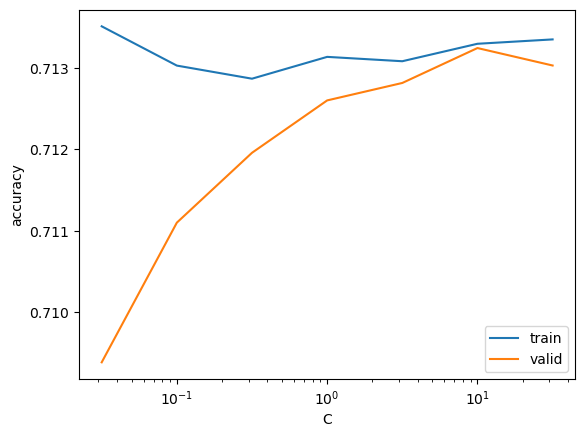

In [14]:
# Adapted from hw4
train_acc = []
cv_acc = []
train_scores = []
cv_scores = []

C_vals = 10.0 ** np.arange(-1.5, 2, 0.5)

for C in C_vals:
    #     print(C)
    pipe = make_pipeline(preprocessor, LogisticRegression(class_weight='balanced',max_iter=1000, C=C, random_state=76))    
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True, scoring=['accuracy','recall'])

    train_acc.append(cv_results["train_accuracy"].mean())
    cv_acc.append(cv_results["test_accuracy"].mean())
    train_scores.append(cv_results["train_recall"].mean())
    cv_scores.append(cv_results["test_recall"].mean())

plt.semilogx(C_vals, train_scores, label="train")
plt.semilogx(C_vals, cv_scores, label="valid")
plt.legend()
plt.xlabel("C")
plt.ylabel("accuracy");

In [15]:
pd.DataFrame({"C": C_vals, "train": train_scores, "cv": cv_scores, "train_accuracies": train_acc, "cv_accuracies": cv_acc})

,C,train,cv,train_accuracies,cv_accuracies
0,0.031623,0.713512,0.709381,0.551631,0.549667
1,0.100000,0.713029,0.711098,0.552417,0.550095
2,0.316228,0.712868,0.711957,0.552274,0.550762
3,1.000000,0.713136,0.712601,0.552333,0.550762
4,3.162278,0.713083,0.712815,0.552286,0.550810
5,10.000000,0.713297,0.713245,0.552393,0.550905
6,31.622777,0.713351,0.713030,0.552298,0.550762


> We get best C value (best cv-score) of `C=10`, with a recall score of ~71.32%. Note that our training and cross validation accuracies are lower than even the dummy classifier. **This is to be expected** because of the use of `class_weight='balanced'`, which will increase the recall (our evaluation metric of choice) at the cost of accuracy. Also note that a recall score of ~71.32% is far superior to the dummy classifier which has a recall score of 0%.

<!-- END QUESTION -->

<br><br>

## 7. Different models <a name="8"></a>
<hr>

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Adapted from hw3
models = {
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=76),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(class_weight='balanced', random_state=76), # Note: This takes a while to perform cross validation on!
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=76)
}

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [17]:
results_dict = {}
for key in models:
    model = models[key]
    pipe = make_pipeline(preprocessor, model)
    results_dict[key] = mean_std_cross_val_scores(
        pipe, X_train, y_train, cv=5, return_train_score=True, scoring='recall'
    )

income_pred_results_df = pd.DataFrame(results_dict).T

/tmp/ipykernel_791/3530482318.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
/tmp/ipykernel_791/3530482318.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
/tmp/ipykernel_791/3530482318.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (m

In [18]:
display(income_pred_results_df)

,fit_time,score_time,test_score,train_score
Decision Tree,0.459 (+/- 0.012),0.012 (+/- 0.000),0.335 (+/- 0.015),1.000 (+/- 0.000)
kNN,0.024 (+/- 0.001),0.483 (+/- 0.015),0.167 (+/- 0.010),0.323 (+/- 0.004)
RBF SVM,23.732 (+/- 0.362),3.726 (+/- 0.034),0.720 (+/- 0.018),0.757 (+/- 0.012)
Random Forest,6.253 (+/- 0.205),0.105 (+/- 0.002),0.181 (+/- 0.009),0.999 (+/- 0.000)


> **Model 1) Decision Tree Classifier:**
>
>  Without hyperparameter optimization of (notably) max_depth, we get a mean cross validation recall score of ~33.53%, but a perfect training recall score of 100%. This greatly suggests overfitting, suggesting that hyperparameter tuning of max_depth would be vital for the viability of DecisionTreeClassifier.

> **Model 2) k-Nearest Neighbours Classifier:**
>
> Without tuning any hyperparameters, we get a mean cross validation recall score of ~16.7%. We also get a training recall score of ~32.3%. The low training and cv scores suggest that there may be underfitting under the default hyperparameters. This will be tuned in the following section. 

> **Model 3) RBF SVM:**
>
> Without tuning any hyperparameters, we get a mean cross validation recall score of ~72.0%, and a training score of ~75.7%. This is quite good for a model without hyperparameter optimization applied yet, and it outperforms the tuned linear model (which had a cv score of ~71.32%). However, due to the high processing time and computing power needed for RBF SVM model fitting, it will be omitted from hyperparameter optimization below in q8.

> **Model 4) Random Forest:**
>
> Without tuning any hyperparameters, we get a a test score of ~18.1% and a training score of ~99.9%. This greatly suggests overfitting. Like the decision tree classifier, tuning of hyperparameters such as max_depth would likely greatly improve the model.

<!-- END QUESTION -->

<br><br>

<!-- END QUESTION -->

<br><br>

## 8. Hyperparameter optimization <a name="10"></a>
<hr>

In [19]:
dt_param_grid = [{
    'decisiontreeclassifier__max_depth': [2, 3, 5, 7, 9], 
}]

dt_pipe = make_pipeline(preprocessor, 
                        models["Decision Tree"]
                       )
dt_grid_search = GridSearchCV(dt_pipe, 
                  param_grid = dt_param_grid, 
                  n_jobs=-1, 
                  return_train_score=True,
                  scoring='recall'
                 ) 
display(dt_grid_search)

dt_grid_search.fit(X_train, y_train)
print(dt_grid_search.best_params_)
print(dt_grid_search.best_score_)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['LIMIT_BAL',
                                                                          'AGE',
                                                                          'BILL_AMT1',
                                                                          'BILL_AMT2',
                                                                          'BILL_AMT3',
                                                                          'BILL_AMT4',
                                                                          'BILL_AMT5',
                                                                          'BILL_AMT6',
                                                                          'PAY_AMT1',
                                                                          'PAY_AMT2',
                                                                          'PAY_AMT3',
                                                                          'PAY_AMT4',
                                                                          'PAY_AMT5',
                                                                          'PAY_AMT6']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       dtype=<class 'int'>,
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['SEX',
                                                                          'MARRIAGE'])])),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               random_state=76))]),
             n_jobs=-1,
             param_grid=[{'decisiontreeclassifier__max_depth': [2, 3, 5, 7,
                                                                9]}],
             return_train_score=True, scoring='recall')

{'decisiontreeclassifier__max_depth': 2}
0.7456595197374185


In [20]:
knn_param_grid = [{ 
    'kneighborsclassifier__n_neighbors': [1, 2, 3, 5, 7, 9]
}]

knn_pipe = make_pipeline(preprocessor, 
                        models["kNN"]
                       )
knn_grid_search = GridSearchCV(knn_pipe, 
                  param_grid = knn_param_grid, 
                  n_jobs=-1, 
                  return_train_score=True,
                  scoring='recall'
                 ) 
display(knn_grid_search)

knn_grid_search.fit(X_train, y_train)
print(knn_grid_search.best_params_)
print(knn_grid_search.best_score_)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['LIMIT_BAL',
                                                                          'AGE',
                                                                          'BILL_AMT1',
                                                                          'BILL_AMT2',
                                                                          'BILL_AMT3',
                                                                          'BILL_AMT4',
                                                                          'BILL_AMT5',
                                                                          'BILL_AMT6',
                                                                          'PAY_AMT1',
                                                                          'PAY_AMT2',
                                                                          'PAY_AMT3',
                                                                          'PAY_AMT4',
                                                                          'PAY_AMT5',
                                                                          'PAY_AMT6']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       dtype=<class 'int'>,
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['SEX',
                                                                          'MARRIAGE'])])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid=[{'kneighborsclassifier__n_neighbors': [1, 2, 3, 5, 7,
                                                                9]}],
             return_train_score=True, scoring='recall')

{'kneighborsclassifier__n_neighbors': 1}
0.28525928555293817


/opt/conda/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [21]:
# Adapted from lecture 08
rf_param_grid = [{ 
    'randomforestclassifier__n_estimators': [75, 100, 125],
    'randomforestclassifier__max_depth': [2, 3, 4], 
}]

rf_pipe = make_pipeline(preprocessor, 
                        models["Random Forest"]
                       )
rf_grid_search = GridSearchCV(rf_pipe, 
                  param_grid = rf_param_grid, 
                  n_jobs=-1, 
                  return_train_score=True,
                  scoring='recall'
                 ) 
display(rf_grid_search)

rf_grid_search.fit(X_train, y_train)
print(rf_grid_search.best_params_)
print(rf_grid_search.best_score_)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['LIMIT_BAL',
                                                                          'AGE',
                                                                          'BILL_AMT1',
                                                                          'BILL_AMT2',
                                                                          'BILL_AMT3',
                                                                          'BILL_AMT4',
                                                                          'BILL_AMT5',
                                                                          'BILL_AMT6',
                                                                          'PAY_AMT1',
                                                                          'PAY_AMT2',
                                                                          'PAY_AMT3',
                                                                          'PAY_AMT4',
                                                                          'PAY_AMT5',
                                                                          'PAY_AMT6']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       dtype=<class 'int'>,
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['SEX',
                                                                          'MARRIAGE'])])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=76))]),
             n_jobs=-1,
             param_grid=[{'randomforestclassifier__max_depth': [2, 3, 4],
                          'randomforestclassifier__n_estimators': [75, 100,
                                                                   125]}],
             return_train_score=True, scoring='recall')

{'randomforestclassifier__max_depth': 2, 'randomforestclassifier__n_estimators': 75}
0.6896354927785436


> ### Summary:
> 
> **Model 1) Decision Tree Classifier:**
> - Best hyperparameters: {'decisiontreeclassifier__max_depth': 2}
> - Best mean cross-validation recall score: 0.7456595197374185
> 
> **Model 2) k-Nearest Neighbours Classifier:**
> - Best hyperparameters: {'kneighborsclassifier__n_neighbors': 1}
> - Best mean cross-validation recall score: 0.2850446932782601
>
> **Model 3) RBF SVM:**
> - Omitted from hyperparameter optimization in the interest of time
>   - (even with randomized search with only **3** RandomizedSearchCV iterations of 5-fold cross validations, that is 3 * 5 * ~20s = ~5 minutes of waiting!)
>  
> **Model 4) Random Forest Classifier:**
> - Best hyperparameters: {'randomforestclassifier__max_depth': 2, 'randomforestclassifier__n_estimators': 75}
> - Best mean cross-validation recall score: 0.6896354927785436

> Out of the models trained, the optimized decision tree classifier with a max-depth of 2 yielded the best mean cross-validation recall score of ~74.57%, with the untuned RBF SVM coming in second with a ~72% mean cv recall score. With additional hyperparameter optimization on the RBF SVM model, it is possible that it would beat the decision tree classifier, but the time cost of doing so is difficult to justify.
>
> Let's take a slightly closer look at the 'winning' model:

In [22]:
best = DecisionTreeClassifier(max_depth=2, class_weight='balanced', random_state=76)
best_pipe = make_pipeline(preprocessor, best)
best_cv_results = pd.DataFrame(
    cross_validate(best_pipe, X_train, y_train, return_train_score=True, scoring=['accuracy','recall'])
)

display(best_cv_results)
best_cv_results.mean()

,fit_time,score_time,test_accuracy,train_accuracy,test_recall,train_recall
0,0.082828,0.011184,0.515238,0.522679,0.744635,0.774886
1,0.075554,0.011587,0.542619,0.547679,0.730687,0.733834
2,0.079994,0.011819,0.549286,0.546071,0.733906,0.733298
3,0.081072,0.011835,0.552857,0.545000,0.745708,0.730614
4,0.077031,0.011561,0.521190,0.521190,0.773362,0.767704


fit_time          0.079296
score_time        0.011597
test_accuracy     0.536238
train_accuracy    0.536524
test_recall       0.745660
train_recall      0.748067
dtype: float64

> Observing the best model that was found, no obvious signs of over/underfitting can be spotted. The cross validation scores are quite similar to the training scores, suggesting the model is generalizable to unseen data.

<!-- END QUESTION -->

<br><br>

<!-- END QUESTION -->

<br><br>

## 9. Results on the test set <a name="12"></a>
<hr>

In [23]:
final_model = best_pipe.fit(X_train, y_train)

test_accuracy = final_model.score(X_test, y_test)

y_predicted = final_model.predict(X_test)
test_recall = recall_score(y_test, y_predicted)

print("Test Accuracy: ", test_accuracy)
print("Test Recall (Evaluation Metric): ", test_recall)

Test Accuracy:  0.5136666666666667
Test Recall (Evaluation Metric):  0.7627718765806778


> Above, we obtained a best mean cross-validation recall of 0.745660 or ~74.57%. Applying the same model to unseen test data, we get a test recall score of ~76.28%, which is quite similar (slightly better) to our expected value. Any slight differences may be a result of random variation. Ultimately, we can conclude that the model generalizes well to *unseen* data, so our results are trustworthy.
>
> Optimization bias was **not** a major issue - evidenced by the performance on unseen data being similar to our model optimized on our training/validation data. Additionally, the model is not very complex; it is a simple cross-validation model with max depth of 2.

<!-- END QUESTION -->

<br><br>

## 10. Summary of Results <a name="13"></a>
<hr>

In [24]:
summary = {'Evaluation Metric': ['Recall'],
           'Final Test Score': [0.7627718765806778],
           'Model': ['DecisionTreeClassifier'],
           'Hyperparameters': ['max_depth=2'],
           'Mean CV-Score': [0.7456595197374185],
           'Fit Time': ['0.580 (+/- 0.080)'],
           'Score Time': ['0.015 (+/- 0.003)'],
           'Dummy Recall': [0]}
summary_df = pd.DataFrame(summary)
display(pd.DataFrame(summary).T) # Display transposed summary

,0
Evaluation Metric,Recall
Final Test Score,0.762772
Model,DecisionTreeClassifier
Hyperparameters,max_depth=2
Mean CV-Score,0.74566
Fit Time,0.580 (+/- 0.080)
Score Time,0.015 (+/- 0.003)
Dummy Recall,0


> - In conclusion, we started by aiming at solving a classification problem of predicting whether a credit card client will default or not. From our EDA, it was observed that class imbalance existed in the dataset, and that we would like to mitigate some risk of type II error (false negative), since this type of error would be most damaging. Thus, our evaluation metric of interest was chosen to be **recall**. We then trained many models under different classifiers ranging from linear models to RBF SVM to our best model, a DecisionTreeClassifier with `max_depth=2`. With this optimized model, we obtained a mean cross-validation recall score of ~74.57% and a final test score of ~76.28% on unseen data, suggesting it is well generalizable to unseen data. Our final model is robust, sensitive, and relatively fast compared to models such as RBF SVM.
> - Further visualizations and analysis of error such as confusion matrices, ROC/AUC, and other techniques explored in lecture 9 (classification metrics) would increase the interpretability, as well as help optimize for ideal evaluation metric conditions. (Such as setting the ideal threshold, or visualizing the tradeoff between precision and recall. Additionally, given more time and resources, I would have liked to fully optimize the hyperparameters of RBF SVM. As seen above, an unoptimized RBF SVM model was the second best model found. Although optimizing its hyperparameters likely wouldn't increase the performance drastically, it may very well be enough to put it on top. Additionally, although I stand by my choice of recall as the test metric, I would like to find a way to maintain both high recall and high accuracy, as the sacrifice in accuracy is quite high in my final model.
> - **Test Metric: Recall**
>    
>    **Final Test Score: 0.7627718765806778 = ~76.28%**